Dans un second temps, passons maintenant à un modèle ayant recours à des réseaux de neurones pour voir si ce dernier est plus efficace pour prédire le cours des actions d'Apple

0 - Préparatifs

Beaucoup de préparatifs vont être les mêmes que dans le modèle du moving average

In [2]:
# Importation des biblothèques 

import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

/Users/antoine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
# On utilise directement pandas
df=pd.read_csv("AAPL.csv")
# On met les dates dans le bon format
df['Date']=pd.to_datetime(df['Date'])
df = df[df['Date'] >= pd.to_datetime('2020-01-01')]
df=df[['Date', 'Close']]

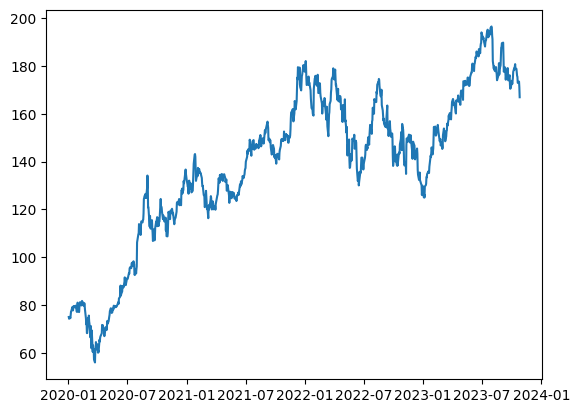

In [11]:
# Rappel de la courbe
plt.plot(df['Date'], df['Close'])

I - Modélisation LSTM

Le but du modèle choisi, modèle LSTM (Lon short-term memory) est de garder quelques valeurs précedentes en mémoire pour prédire la prochaine valeur avec une manière de prédire plus complexe qu'une relation linéaire ou de moyenne.

On commence alors par créer une fonction qui va nous renvoyer notre dataframe avec des colonnes ajoutées : à savoir les valeurs de 'Close' aux 4 jours qui suivent notre date. La quatrième valeur est appelée "Target". Target est ainsi la valeur à T+4 de 'Close'

In [7]:
# On commence par définir nos décalages qui vont nous permettre de prendre les valeurs du futur 
shifts=[-1, -2, -3, -4]

In [6]:

def add_shifted_columns(df, shifts):
  
  for index, Target in enumerate(shifts): # On conserve l'index car il nous servira
                                             # On boucle sur toutes les valeurs pour ajouter toutes les colonnes

    df_temp=df['Close'].shift(Target) # Utilisation de la fonction shift de panda : 
                                         # df.['Close].shift[-1] renvoie la valeur suivante de Close (par rapport au temps dans la boucle)
    if index<(len(shifts)-1):
      col_name=f'Target - {index+1}' # On crée le nom de colonne Target - n (on réequilibre l'index qui commençait à 0)

    else:
      col_name='Target' # Si on est au bout de la liste de décalages, alors on a atteint notre target

    df[col_name]=df_temp # On ajoute la colonne avec son nouveau nom à notre tableau final à l'aide de notre tableau temporaire

    df['Target Date']=df['Date'].shift(-len(shifts)) # On ajoute la date associée au Target final

  return df


In [12]:
# Testons le résultat

df = add_shifted_columns(df,shifts)
df

,Date,Close,Target - 1,Target Date,Target - 2,Target - 3,Target
9847,2020-01-02,75.087502,74.357498,2020-01-08,74.949997,74.597504,75.797501
9848,2020-01-03,74.357498,74.949997,2020-01-09,74.597504,75.797501,77.407501
9849,2020-01-06,74.949997,74.597504,2020-01-10,75.797501,77.407501,77.582497
9850,2020-01-07,74.597504,75.797501,2020-01-13,77.407501,77.582497,79.239998
9851,2020-01-08,75.797501,77.407501,2020-01-14,77.582497,79.239998,78.169998
...,...,...,...,...,...,...,...
10804,2023-10-20,172.880005,173.000000,2023-10-26,173.440002,171.100006,166.889999
10805,2023-10-23,173.000000,173.440002,NaT,171.100006,166.889999,NaN
10806,2023-10-24,173.440002,171.100006,NaT,166.889999,NaN,NaN
10807,2023-10-25,171.100006,166.889999,NaT,NaN,NaN,NaN


In [18]:
# On replace Target Date au sein du tableau pour plus d'esthétique
ordre_colonnes = ['Date', 'Close', 'Target Date', 'Target - 1', 'Target - 2', 'Target - 3', 'Target']
df = df[ordre_colonnes]

On rappelle que l'existence de trous entre les dates est liée à la fermeture des marchés pendant les week-ends.

On entre plus en profondeur dans la modélisation, ainsi la date originale et la valeur originale de Close ne nous intéressent plus, il vient :

In [19]:
df=df.drop(['Date', 'Close'],axis=1)

,Target Date,Target - 1,Target - 2,Target - 3,Target
9847,2020-01-08,74.357498,74.949997,74.597504,75.797501
9848,2020-01-09,74.949997,74.597504,75.797501,77.407501
9849,2020-01-10,74.597504,75.797501,77.407501,77.582497
9850,2020-01-13,75.797501,77.407501,77.582497,79.239998
9851,2020-01-14,77.407501,77.582497,79.239998,78.169998
